In [1]:
%load_ext autoreload
%autoreload 2

### 1. Load expression data

The `transformation` value can be one of `"none"`, `"sqrt"` or `"log"`, which determines how the expression data should be transformed in order to reduce outlier influence.

In [2]:
data_path = "data/Athaliana.csv"
transformation = "sqrt"

In [8]:
from my_gatai import Expression_data

expression_data = Expression_data.from_csv(data_path, 
                                           transformation="sqrt")

#### 1.1 Compute TAI value

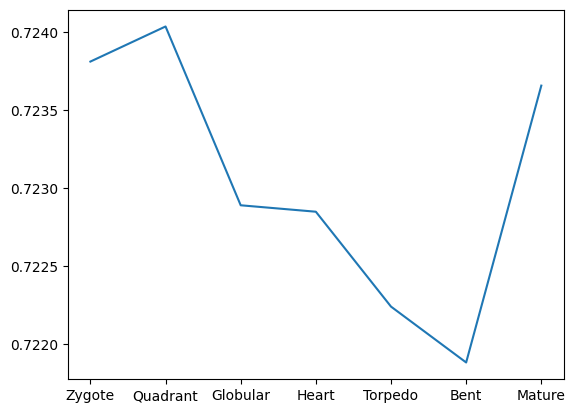

In [12]:
import matplotlib.pyplot as plt

plt.plot(expression_data.tai)
plt.show()

### 2. Flatline test

#### 2.1. Compute variance of TAI curve

In [13]:
import numpy as np
tai_var = np.var(expression_data.tai).item()
tai_var

5.704724792575682e-07

#### 2.2. Compute permutation variance distribution

Permute the assigned gene ages between the genes to run the flat line test

In [14]:
from gatai.utils import comp_vars

num_permutations = 10000
permutation_comp_vars = comp_vars(expression_data, num_permutations)

Running permuations


100%|██████████| 10000/10000 [00:04<00:00, 2248.05it/s]


#### 2.3. Fit the random variances to a Gamma distribution and compute the p-value of the true TAI

In [15]:
import scipy.stats as stats

# NOTE: the default fitting method used by scipy doesn't achieve a very good fit, so use "MM"
a, loc, scale = stats.gamma.fit(permutation_comp_vars, method="MM")
print(a, loc, scale)

0.882063455987268 5.341623689483937e-09 3.133686819458192e-08


p-value

In [16]:
print(stats.gamma.sf(tai_var, a, loc=loc, scale=scale))

9.599223017005398e-09


#### 2.4. Visually compare the random TAI variances against the true one

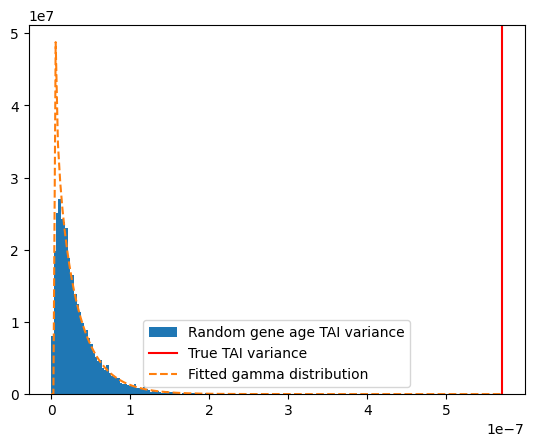

In [17]:
plt.hist(permutation_comp_vars, density=True, bins=100, label="Random gene age TAI variance")
plt.axvline(x=tai_var, label="True TAI variance", color="red")

x = np.linspace(0, tai_var, 200)
y = stats.gamma.pdf(x, a, loc=loc, scale=scale)
plt.plot(x, y, label="Fitted gamma distribution", linestyle="dashed")

plt.legend()
plt.show()

### 3. Destroy TAI signal with GATAI

#### 3.1 Run genetic algorithm to extract genes that break the pattern
Note that the transformation used for the expression data heavily influences the number of genes that get extracted, as well as the number of generations needed for convergence.

Also, with transformations applied, older genes are better represented

In [18]:
from my_gatai import get_extracted_genes

genes = get_extracted_genes(expression_data, permutation_comp_vars)

gen	island	Num removed	Variance
0  	      	4          	1.98426 
10 	1     	451        	1.66669 
10 	2     	537        	1.66323 
10 	3     	449        	1.71575 
10 	4     	486        	1.8956  


20 	1     	738        	1.53814 
20 	2     	835        	1.52121 
20 	3     	671        	1.56484 
20 	4     	619        	1.63386 


30 	1     	782        	1.47277 
30 	2     	804        	1.42588 
30 	3     	1303       	1.44471 
30 	4     	1180       	1.47074 


40 	1     	1384       	1.43223 
40 	2     	706        	1.42699 
40 	3     	781        	1.39467 
40 	4     	911        	1.40998 


50 	1     	879        	1.37327 
50 	2     	1081       	1.36422 
50 	3     	736        	1.35701 
50 	4     	988        	1.3743  


60 	1     	796        	1.32506 
60 	2     	1032       	1.32965 
60 	3     	1246       	1.33637 
60 	4     	850        	1.3468  


70 	1     	1245       	1.31595 
70 	2     	772        	1.33106 
70 	3     	892        	1.30344 
70 	4     	1093       	1.31825 


80 	1     	1200       	1.2

In [19]:
len(genes)

191

#### 3.2 Check variance of destroyed TAI and its new p-value

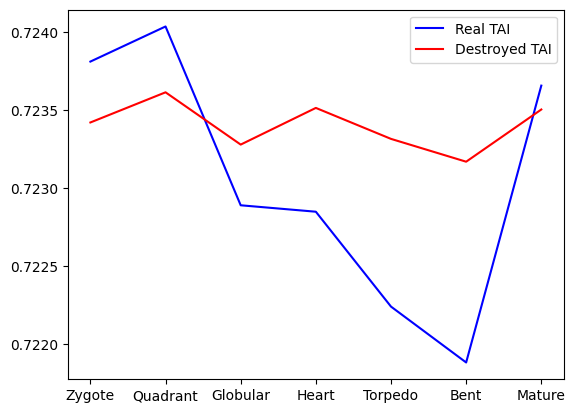

In [20]:
new_data = expression_data.remove_genes(genes)
plt.plot(expression_data.tai, label="Real TAI", color="blue")
plt.plot(new_data.tai, label="Destroyed TAI", color="red")

plt.legend()
plt.show()

p-value

In [21]:
new_tai_var = np.var(new_data.tai).item()
print(stats.gamma.sf(new_tai_var, a, loc=loc, scale=scale))

0.552854284934312


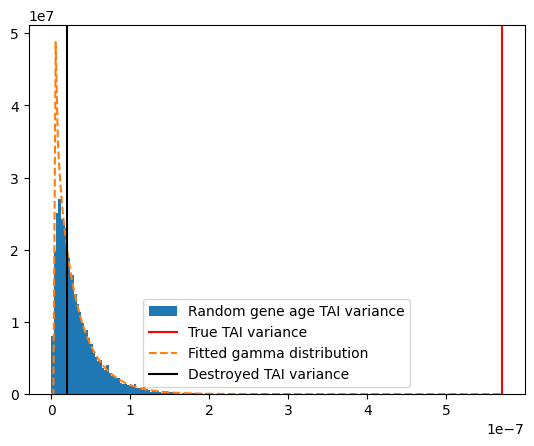

In [22]:
plt.hist(permutation_comp_vars, density=True, bins=100, label="Random gene age TAI variance")
plt.axvline(x=tai_var, label="True TAI variance", color="red")


x = np.linspace(0, tai_var, 200)
y = stats.gamma.pdf(x, a, loc=loc, scale=scale)
plt.plot(x, y, label="Fitted gamma distribution", linestyle="dashed")
plt.axvline(x=new_tai_var, label="Destroyed TAI variance", color="black")
plt.legend()
plt.show()

#### 3.3 Benchmark GA against greedy removal of genes with highest variance

In [26]:
gene_variances = expression_data.gene_variances.sort_values('Variance')
gene_variances

,Phylostratum,GeneID,Variance
6275,0.665923,AT4G23000,0.004941
20844,0.930387,AT4G10420,0.010001
11964,0.665923,AT3G08505,0.011695
11434,0.665923,AT2G36740,0.012674
7009,0.665923,AT5G02080,0.012863
...,...,...,...
21773,0.937799,AT2G42560,5562.334849
13900,0.954933,AT4G36600,5833.021106
19986,0.979001,AT1G32560,6055.077971
23426,0.994581,AT1G03106,6330.254124


In [28]:
k_top = len(genes)

highest_var_genes = gene_variances.head(k_top)['GeneID'].to_numpy()
highest_var_genes

array(['AT4G23000', 'AT4G10420', 'AT3G08505', 'AT2G36740', 'AT5G02080',
       'AT2G22890', 'AT4G34430', 'AT4G21366', 'AT5G25790', 'AT5G01820',
       'AT4G32990', 'AT4G09630', 'AT5G25415', 'AT1G17950', 'AT1G26798',
       'AT1G44170', 'AT3G56570', 'AT5G47900', 'AT3G47390', 'AT2G19960',
       'AT5G56510', 'AT5G43380', 'AT1G57590', 'AT5G43530', 'AT4G24230',
       'AT4G30000', 'AT4G12050', 'AT3G21470', 'AT5G50310', 'AT4G26350',
       'AT1G29960', 'AT4G34540', 'AT4G14210', 'AT1G55560', 'AT1G22810',
       'AT5G03790', 'AT4G29660', 'AT3G49350', 'AT1G02430', 'AT5G28220',
       'AT4G27950', 'AT2G18010', 'AT4G20330', 'AT4G31850', 'AT4G36120',
       'AT5G20260', 'AT5G37380', 'AT4G37950', 'AT1G24090', 'AT5G04230',
       'AT5G23320', 'AT1G77460', 'AT3G51590', 'AT4G36630', 'AT3G09540',
       'AT1G50030', 'AT3G61200', 'AT5G37415', 'AT5G07760', 'AT3G17980',
       'AT4G37650', 'AT5G17450', 'AT3G51790', 'AT4G38510', 'AT5G40020',
       'AT5G39500', 'AT3G26780', 'AT3G20280', 'AT2G04450', 'AT3G

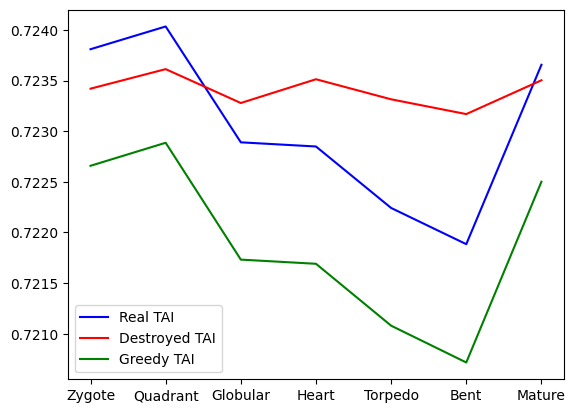

In [31]:
greedy_data = expression_data.remove_genes(highest_var_genes)
plt.plot(expression_data.tai, label="Real TAI", color="blue")
plt.plot(new_data.tai, label="Destroyed TAI", color="red")
plt.plot(greedy_data.tai, label="Greedy TAI", color="green")

plt.legend()
plt.show()

Conversely, however, the genes that were extracted by GATAI tend to have a high variance (but they need to be carefully selected, it's not as simple as picking the most variant ones, hence the need for the GA approach)

#### 3.4 Stability of solutions